# Latent Dirichlet Allocation (LDA)

In this notebook a `gensim` LDA model is applied to the tweets to identify
topics.

## Load data

Convert the SQLite to csv format.

In [1]:
from brexittweets.custom_funcs.sqlite_functions import save_to_csv

save_to_csv()

Read the data from the CSV to a Pandas DataFrame.
Separate into training data (df) and a small testing dataset (test_df).

In [30]:
import pandas as pd
from brexittweets.config import tweets_csv_path

df = pd.read_csv(tweets_csv_path).sample(frac=1, axis=0, random_state=42)
df.reset_index(inplace=True)
df.pop('index')
df.head()

,tweet_id,tweet_text
0,8004,that and the brexit movie didnt get nearly en...
1,9494,seeing a poster for an independence march in w...
2,8563,no worries im sure the eu will spring into act...
3,7518,yeah brexit britain is fine were all happy i n...
4,9062,posted


## Text pre-processing

Tokenise the tweets and perform lemmatisation and stemming.

In [31]:
from brexittweets.custom_funcs.process_text_functions import tokenize_tag,stem_lemmatize

preprocessed_tokenized = []

for tweet in df['tweet_text']:
    # tokenise tweet text
	tokenized_tweet = tokenize_tag(tweet)
    # add to list of tokenised tweets
	preprocessed_tokenized.append(stem_lemmatize(tokenized_tweet))
    
#Check that tokenisation, stemming and lemmatization has worked.
preprocessed_tokenized[0]

['brexit',
 'movi',
 'didnt',
 'near',
 'attent',
 'peopl',
 'dont',
 'want',
 'shitti',
 'futur',
 'chernobyl',
 'failur',
 'past',
 'attent']

## Building the dictionary

Using the `gensim` package, create a dictionary of words from the tweets.

Given that the Tweets are already filtered to include the 'Brexit' topic, it is 
likely that some topic-relevant words will appear in upward of 80% of tweets.
Words that appear in more than 50% of tweets are filtered
to remove the most common words (e.g. 'Brexit' - we know that's the subject!)

In [32]:
import gensim

dictionary = gensim.corpora.Dictionary(preprocessed_tokenized)
# Filter most common words
dictionary.filter_extremes(no_above=0.5)

print(len(dictionary))

2752


This leaves us with 2752 words to use for the model.

# Bag of Words Corpus

Use doc2bow to count the number of occurrences of each token, for each tweet in the list of tokenized tweets.
This generates `bow_corpus`, a list of tuples (x,y) where x is the index in the dictionary of the 
word and y is the count of the word.

Extract one tweet from the corpus to demonstrate.

In [33]:
# Create BOW corpus from list of tokenised tweets
bow_corpus = [dictionary.doc2bow(tweet) for tweet in preprocessed_tokenized]

# Get tweet at location 100
example_tweet = df.loc[100,'tweet_text']
print(example_tweet)
# Get BOW entry at index 100
example_tweet_bow = bow_corpus[100]
for example_word, example_word_count in example_tweet_bow:
    # Show count for each word in Tweet
    print(f'Word {dictionary[example_word]} occurs {example_word_count} times.')

 can you explain how have you seen whats going on in italy are you ready for close pub university school and office will be worse than brexit i think
Word see occurs 1 times.
Word think occurs 1 times.
Word go occurs 1 times.
Word bad occurs 1 times.
Word close occurs 1 times.
Word explain occurs 1 times.
Word itali occurs 1 times.
Word offic occurs 1 times.
Word readi occurs 1 times.
Word school occurs 1 times.
Word univers occurs 1 times.
Word what occurs 1 times.


## LDA model (Bag of Words)

Fit a gensim LdaMulticore model to the bag-of-words data.

In [34]:
lda_model_bow = gensim.models.LdaMulticore(bow_corpus,
                                           num_topics=3,
                                           id2word=dictionary,
                                           passes=2,
                                           workers=4,
                                           random_state=42)

import re

# Extract the words and their frequencies from the three topics
topics = {}

for num, topic in lda_model_bow.print_topics(-1):
    list_words = re.findall('"[a-z]+"', topic)
    list_freqs = re.findall('0\.[0-9]+', topic)
    topics[num] = zip(list_words, list_freqs)
    
for num, topic in topics.items():
    print(f'Topic {num}:')
    for word, freq in topic:
        print(f'Word: {word}\tFrequency: {freq}')


<>:15: DeprecationWarning: invalid escape sequence \.
<>:15: DeprecationWarning: invalid escape sequence \.
<>:15: DeprecationWarning: invalid escape sequence \.
<ipython-input-34-dbd5e14024a8>:15: DeprecationWarning: invalid escape sequence \.
  list_freqs = re.findall('0\.[0-9]+', topic)


Topic 0:
Word: "deal"	Frequency: 0.012
Word: "trade"	Frequency: 0.012
Word: "leav"	Frequency: 0.011
Word: "vote"	Frequency: 0.010
Word: "peopl"	Frequency: 0.009
Word: "mean"	Frequency: 0.008
Word: "ireland"	Frequency: 0.008
Word: "johnson"	Frequency: 0.007
Word: "like"	Frequency: 0.007
Word: "tori"	Frequency: 0.006
Topic 1:
Word: "vote"	Frequency: 0.013
Word: "countri"	Frequency: 0.010
Word: "labour"	Frequency: 0.009
Word: "happen"	Frequency: 0.009
Word: "know"	Frequency: 0.007
Word: "postbrexit"	Frequency: 0.007
Word: "elect"	Frequency: 0.007
Word: "go"	Frequency: 0.007
Word: "support"	Frequency: 0.006
Word: "like"	Frequency: 0.006
Topic 2:
Word: "vote"	Frequency: 0.014
Word: "think"	Frequency: 0.013
Word: "peopl"	Frequency: 0.013
Word: "like"	Frequency: 0.011
Word: "right"	Frequency: 0.009
Word: "passport"	Frequency: 0.008
Word: "say"	Frequency: 0.008
Word: "dont"	Frequency: 0.008
Word: "want"	Frequency: 0.008
Word: "come"	Frequency: 0.008


## Evaluate the BOW model

Based on the words in the topics, they appear to reflect:

- **Topic 0** :- Boris Johnson and the Conservative ('tori') government negotiating a trade deal, and uncertainty
around Northern Ireland's border and status within the UK (BBC News, 2020a).
- **Topic 1** :- The general election of 2019 (based on the words 'vote', 'country', 'labour', 'elect' and 'support'
(BBC News, 2019a)
- **Topic 2** :- Reactions to the announcement that new passports would be rolled out from March 2020 (BBC News, 2020b)

Examine the coherence of the model

In [35]:
# Coherence
from gensim.models import CoherenceModel
coherence_bow = CoherenceModel(model=lda_model_bow, 
                               texts=preprocessed_tokenized, 
                               dictionary=dictionary, 
                               coherence='c_v')
coherence_lda = coherence_bow.get_coherence()
print(f'Coherence Score: {coherence_lda}')

Coherence Score: 0.17761323735106893


## Term Frequency Inverse Document Frequency Corpus

Generate a Tf-idf model using the Bag-of-words model. 
Tf-idf down-weights more common words.

In [36]:
# Generate Tf-idf corpus
tfidf = gensim.models.TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]

In [37]:
# LDA Multicore model using Tf-idf corpus
lda_model_tfidf = gensim.models.LdaMulticore(tfidf_corpus, 
                                             num_topics=3, 
                                             id2word=dictionary, 
                                             passes=2, 
                                             workers=4,
                                             random_state=42)

# Extract topic words and frequencies to print
topics = {}

for num, topic in lda_model_tfidf.print_topics(-1):
    list_words = re.findall('"[a-z]+"', topic)
    list_freqs = re.findall('0\.[0-9]+', topic) 
    topics[num] = zip(list_words, list_freqs)
    
for num, topic in topics.items():
    print(f'Topic {num}:')
    for word, freq in topic:
        print(f'Word: {word}\tFrequency: {freq}')

<>:14: DeprecationWarning: invalid escape sequence \.
<>:14: DeprecationWarning: invalid escape sequence \.
<>:14: DeprecationWarning: invalid escape sequence \.
<ipython-input-37-c4f5a9dbcdf9>:14: DeprecationWarning: invalid escape sequence \.
  list_freqs = re.findall('0\.[0-9]+', topic)


Topic 0:
Word: "mean"	Frequency: 0.011
Word: "deal"	Frequency: 0.007
Word: "vote"	Frequency: 0.006
Word: "ireland"	Frequency: 0.006
Word: "trade"	Frequency: 0.006
Word: "leav"	Frequency: 0.005
Word: "northern"	Frequency: 0.005
Word: "british"	Frequency: 0.005
Word: "risk"	Frequency: 0.005
Word: "peopl"	Frequency: 0.005
Topic 1:
Word: "happen"	Frequency: 0.009
Word: "vote"	Frequency: 0.006
Word: "postbrexit"	Frequency: 0.005
Word: "countri"	Frequency: 0.005
Word: "know"	Frequency: 0.005
Word: "remind"	Frequency: 0.005
Word: "bori"	Frequency: 0.004
Word: "march"	Frequency: 0.004
Word: "like"	Frequency: 0.004
Word: "labour"	Frequency: 0.004
Topic 2:
Word: "vote"	Frequency: 0.009
Word: "think"	Frequency: 0.007
Word: "say"	Frequency: 0.007
Word: "peopl"	Frequency: 0.006
Word: "passport"	Frequency: 0.006
Word: "like"	Frequency: 0.006
Word: "right"	Frequency: 0.005
Word: "come"	Frequency: 0.005
Word: "year"	Frequency: 0.005
Word: "want"	Frequency: 0.004


## Evaluate the Tf-idf model

Inspecting the word choices, the topics appear to be as follows:

1. Uncertainty around Northern Ireland's border and status within the UK in light of the trade deal being negotiated 
(BBC News, 2020a). 
2. This echoes Boris Johnson's election promise to "Get Brexit Done" (BBC News, 2019b) - with words like "vote", 
"happen", and "postbrexit" being most prominent.
3. This seems to be about the new passports being rolled out from March (BBC News, 2020b).

Examine the coherence of the model

In [38]:
# Coherence
from gensim.models import CoherenceModel
coherence_tfidf = CoherenceModel(model=lda_model_tfidf, 
                                 texts=preprocessed_tokenized, 
                                 dictionary=dictionary, 
                                 coherence='c_v')
coherence_score_tfidf = coherence_tfidf.get_coherence()
print(f'Coherence Score: {coherence_score_tfidf}')

Coherence Score: 0.24275298340676602


## Hyperparameter tuning

In order to maximise the coherence of the model, re-train the model using
both BOW corpus and Tf-idf corpus, and using several different values of
alpha affects the 'sparsity' of the topics (Prabhakaran, 2018), so picking the right value
will maximise the coherence.

In [39]:
import numpy as np
from typing import List

# Length of corpus
tweet_count = len(tfidf_corpus)

# Range of possible alpha values
alphas = list(np.arange(0.01,1,0.1))

def tuning(alpha_list: List) -> pd.DataFrame:
    """
    Accepts a list of possible alpha values, iterates through the
    list and retrains an LDA Multicore model on each alpha value, for
    each of the BOW and Tfidf corpuses.
    Returns DataFrame of results.
    """
    # Parameters and results stored in dictionary
    params = {'alpha': [], 'corpus' : [], 'coherence_score': []}
    # Choice of corpus options
    corpus_options = {'bow': bow_corpus,
                      'tfidf': tfidf_corpus}
    
    # Iterate through corpus options
    for corpus_name, corpus in corpus_options.items():
        # Iterate through alpha values
        for alpha in alpha_list:
            # Retrain model
            lda_tuning = gensim.models.LdaMulticore(corpus, 
                                               num_topics=3, 
                                               id2word=dictionary, 
                                               passes=2, 
                                               workers=4, 
                                               alpha=alpha,
                                               random_state=42)
            # Calculate coherence
            cs = CoherenceModel(model=lda_tuning, 
                                texts=preprocessed_tokenized, 
                                dictionary=dictionary, 
                                coherence='c_v')
            # Print progress
            print(f"Complete: alpha {alpha}, corpus {corpus_name}")
            # Add parameters and results to dictionary
            params['coherence_score'].append(cs.get_coherence())
            params['alpha'].append(alpha)
            params['corpus'].append(corpus_name)
    # Display results
    params_df = pd.DataFrame(data = params)
    return params_df

# Get results
params_compare = tuning(alphas)
# Sort from best coherence score to worst and display
params_compare.sort_values(by='coherence_score', ascending=False)

Complete: alpha 0.01, corpus bow
Complete: alpha 0.11, corpus bow
Complete: alpha 0.21000000000000002, corpus bow
Complete: alpha 0.31000000000000005, corpus bow
Complete: alpha 0.41000000000000003, corpus bow
Complete: alpha 0.51, corpus bow
Complete: alpha 0.6100000000000001, corpus bow
Complete: alpha 0.7100000000000001, corpus bow
Complete: alpha 0.81, corpus bow
Complete: alpha 0.91, corpus bow
Complete: alpha 0.01, corpus tfidf
Complete: alpha 0.11, corpus tfidf
Complete: alpha 0.21000000000000002, corpus tfidf
Complete: alpha 0.31000000000000005, corpus tfidf
Complete: alpha 0.41000000000000003, corpus tfidf
Complete: alpha 0.51, corpus tfidf
Complete: alpha 0.6100000000000001, corpus tfidf
Complete: alpha 0.7100000000000001, corpus tfidf
Complete: alpha 0.81, corpus tfidf
Complete: alpha 0.91, corpus tfidf


,alpha,corpus,coherence_score
13,0.31,tfidf,0.250836
12,0.21,tfidf,0.236854
14,0.41,tfidf,0.230768
10,0.01,tfidf,0.227643
11,0.11,tfidf,0.224339
15,0.51,tfidf,0.198047
0,0.01,bow,0.185564
4,0.41,bow,0.183438
3,0.31,bow,0.183438
2,0.21,bow,0.183011


The highest coherence scores appear using the 'tf-idf' corpus, which 
will be used from now on. The relationship between the alpha value and
the coherence score will be visualised.

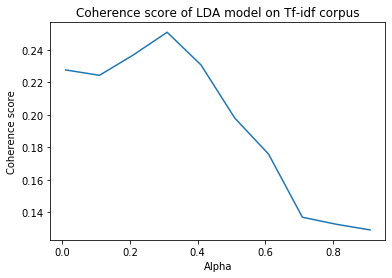

In [40]:
import matplotlib.pyplot as plt

# Filter DataFrame to include only tf-idf model results
params_tfidf = params_compare.copy()[params_compare.corpus=='tfidf']

# Set y = coherence scores and x = alpha values
y_alpha = params_tfidf['coherence_score']
x = params_tfidf['alpha']

# plot using matplotlib
plt.plot(x,y_alpha)
plt.xlabel('Alpha')
plt.ylabel('Coherence score')
plt.title('Coherence score of LDA model on Tf-idf corpus')
plt.show()


In [41]:
# select best coherence score and associated alpha value
coherence_score_best = max(params_tfidf['coherence_score'])
alpha_score_best = params_tfidf[params_tfidf.coherence_score==coherence_score_best]['alpha'].values[0]

# retrain model
lda_model_tuned = gensim.models.LdaMulticore(tfidf_corpus, 
                                             num_topics=3, 
                                             id2word=dictionary, 
                                             passes=2, 
                                             workers=4,
                                             alpha=alpha_score_best,
                                             random_state=42)

topics = {}

for num, topic in lda_model_tuned.print_topics(-1):
    list_words = re.findall('"[a-z]+"', topic)
    list_freqs = re.findall('0\.[0-9]+', topic) 
    topics[num] = zip(list_words, list_freqs)
    
for num, topic in topics.items():
    print(f'Topic {num}:')
    for word, freq in topic:
        print(f'Word: {word}\tFrequency: {freq}')

print('Coherence: ',
      CoherenceModel(model=lda_model_tuned, 
                     texts=preprocessed_tokenized, 
                     dictionary=dictionary, 
                     coherence='c_v').get_coherence())

<>:18: DeprecationWarning: invalid escape sequence \.
<>:18: DeprecationWarning: invalid escape sequence \.
<>:18: DeprecationWarning: invalid escape sequence \.
<ipython-input-41-838aa4a4a0dd>:18: DeprecationWarning: invalid escape sequence \.
  list_freqs = re.findall('0\.[0-9]+', topic)


Topic 0:
Word: "mean"	Frequency: 0.011
Word: "deal"	Frequency: 0.007
Word: "ireland"	Frequency: 0.006
Word: "vote"	Frequency: 0.006
Word: "trade"	Frequency: 0.006
Word: "leav"	Frequency: 0.005
Word: "northern"	Frequency: 0.005
Word: "british"	Frequency: 0.005
Word: "risk"	Frequency: 0.005
Word: "pledg"	Frequency: 0.005
Topic 1:
Word: "happen"	Frequency: 0.009
Word: "vote"	Frequency: 0.007
Word: "postbrexit"	Frequency: 0.005
Word: "countri"	Frequency: 0.005
Word: "know"	Frequency: 0.005
Word: "remind"	Frequency: 0.005
Word: "bori"	Frequency: 0.004
Word: "march"	Frequency: 0.004
Word: "like"	Frequency: 0.004
Word: "occur"	Frequency: 0.004
Topic 2:
Word: "vote"	Frequency: 0.009
Word: "think"	Frequency: 0.007
Word: "say"	Frequency: 0.007
Word: "peopl"	Frequency: 0.006
Word: "passport"	Frequency: 0.006
Word: "like"	Frequency: 0.006
Word: "right"	Frequency: 0.005
Word: "come"	Frequency: 0.005
Word: "year"	Frequency: 0.005
Word: "want"	Frequency: 0.004
Coherence:  0.25083581507490676


In [42]:
# Visualise the topics to explore
import pyLDAvis
import pyLDAvis.gensim as pg
pyLDAvis.enable_notebook()
vis = pg.prepare(lda_model_tfidf, tfidf_corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.007600 -0.062496       1        1  37.205837
0     -0.065962  0.025518       2        1  31.813505
1      0.058362  0.036979       3        1  30.980659, topic_info=        Term        Freq       Total Category  logprob  loglift
41      mean  120.000000  120.000000  Default  30.0000  30.0000
295  ireland   58.000000   58.000000  Default  29.0000  29.0000
84    happen  106.000000  106.000000  Default  28.0000  28.0000
297    pledg   42.000000   42.000000  Default  27.0000  27.0000
86    remind   40.000000   40.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
457  johnson   25.247374   73.618233   Topic3  -5.7741   0.1016
8      peopl   30.256723  130.061844   Topic3  -5.5931  -0.2865
2       dont   26.959032   95.325867   Topic3  -5.7085  -0.0912
10      want   26.023277   91.914902   Topic3  -5.7438  -0.0901
35      deal   24.672104  106.849167   Topic3  -5.7971  -0.2939

[252 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
338       1  0.734020  actual
338       2  0.108744  actual
338       3  0.135930  actual
52        1  0.134349  affect
52        2  0.828488  affect
...     ...       ...     ...
648       2  0.657216   wrong
648       3  0.202220   wrong
183       1  0.548240    year
183       2  0.238365    year
183       3  0.214529    year

[488 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

There does not appear to be overlap between the topics.

The first topic appears to be the risk to the EU trade deal if the UK goes against special arrangements made for Northern Ireland (The Guardian, 
2020). This topic will be named 'Northern Ireland Border'

Topics 2 and 3 are examined below

In [43]:
from typing import Dict, Tuple

def get_ids(word_list: List[str]) -> Dict:
    """
    Searches dictionary for each word in list and returns dictionary
    of the words with their index in the dictionary
    """
    word_ids = {}
    for key, value in dictionary.items():
        for wrd in word_list:
            if value == wrd:
                word_ids[wrd] = key
        if len(word_ids)==len(word_list):
            # Stop searching dictionary if all words are found
            return word_ids
        
# Look for words from topics in dictionary to fetch their ids
word_ids_1 = get_ids([x[0] for x in lda_model_tuned.show_topic(1)])
word_ids_2 = get_ids([x[0] for x in lda_model_tuned.show_topic(2)])
print(word_ids_1)
print(word_ids_2)

{'march': 17, 'vote': 50, 'happen': 84, 'occur': 85, 'remind': 86, 'countri': 91, 'like': 146, 'know': 303, 'postbrexit': 375, 'bori': 627}
{'peopl': 8, 'want': 10, 'right': 43, 'vote': 50, 'think': 110, 'like': 146, 'year': 183, 'passport': 202, 'say': 376, 'come': 620}


In [44]:
def get_tweets_with_words(word_id_dict: Dict) -> List:
    """
    Accepts list of indices for words in dictionary, and searches
    BOW corpus of Tweets for any containing 4 or more of the words
    from the list. Returns indices of corpus for each of these
    lists where 4+ words are found. 
    """
    tweet_locs = []
    # iterate through BOW corpus
    for i in range(len(bow_corpus)):
        count = 0
        # Check whether index of word in corpus matches one in list
        for num_tuple in bow_corpus[i]:
            for key, value in word_id_dict.items():
                if num_tuple[0]==value:
                    # Count each hit
                    count += 1
        # Any tweet with more than 3 appropriate words is added to the list to be returned
        if count > 3:
            tweet_locs.append(i)
    return tweet_locs
            
# Find ids of tweets containing 4+ words from topics 2 and 3
tweet_locs_1 = get_tweets_with_words(word_ids_1)
tweet_locs_2 = get_tweets_with_words(word_ids_2)
print(tweet_locs_1)
print(tweet_locs_2)

[9, 40, 203, 555, 701, 749, 859, 1308, 1642, 1885, 2152, 2506, 2548, 2554, 2715, 2733, 2857, 3112, 3284, 3347, 4078, 4255, 4258, 4320, 4933, 4936, 5005, 5138, 5152, 5334, 5666, 5942, 5972, 6394, 6419, 6538, 6694, 6887, 7239, 7276, 7453, 7501, 7584, 7751, 7831, 8120, 8198, 8244, 8319, 8797, 9264, 9347, 9353, 9363, 9382, 9666, 9668, 9677, 9808, 9814, 10400]
[110, 243, 321, 476, 731, 1141, 1433, 1522, 1574, 2039, 2539, 3047, 3094, 3276, 3393, 3828, 3910, 3979, 4236, 4301, 4638, 4668, 4751, 5288, 5337, 5542, 5888, 6050, 6077, 6090, 6886, 7399, 9184, 9717, 9724, 10289]


In [45]:
def print_sample(tweet_locs: List[int]) -> None:
    """
    Iterates through list of tweet ids, locates the id in the 
    DataFrame of Tweets and prints the text of the Tweet.
    """
    c = 0
    for tweet_id in tweet_locs:
        print(df.loc[tweet_id,'tweet_text'])
        c+=1
        if c>10:
            break

print("Tweets from topic 1")
print_sample(tweet_locs_1)
print("\n\nTweets from topic 2")
print_sample(tweet_locs_2)

Tweets from topic 1
 hi just a reminder that brexit has not happened yet it is due to occur on the th march 
 hi just a reminder that brexit has not happened yet it is due to occur on the th march 
 hi just a reminder that brexit has not happened yet it is due to occur on the th march 
 hi just a reminder that brexit has not happened yet it is due to occur on the th march 
 hi just a reminder that brexit has not happened yet it is due to occur on the th march 
 hi just a reminder that brexit has not happened yet it is due to occur on the th march 
 hi just a reminder that brexit has not happened yet it is due to occur on the th march 
 hi just a reminder that brexit has not happened yet it is due to occur on the th march 
 when brexit happened many of us blamed only the politicians for their lies and concluded that the  were guilty only of being deceived   that was condescending  wrong whoever voted for these rogues are knowingly complicit  accountable for what this country has become


Topic 2 seems to have been influenced by the action of a Bot (since deleted but a footprint
still exists on Google's search page (BrexitBot, 2020). The Bot automatically responds to Tweets discussing
the state of affairs after Brexit. It also seems to be outdated.

To more closely examine the third topic, Tweets containing the three most frequent terms were 
found.

In [46]:
# Use just highest frequency words
word_ids_2_most_common = get_ids(['vote', 'think', 'say', 'peopl'])
tweet_locs_2_most_common = get_tweets_with_words(word_ids_2_most_common)
print("Tweets from topic 2 using only most common words")
print_sample(tweet_locs_2_most_common)
for tweet in tweet_locs_2_most_common:
    print(df.loc[tweet, ['tweet_id', 'tweet_text']])

Tweets from topic 2 using only most common words
 i despise him and he despises people like me hes said plenty about us labelling us and not forgetting that sabisky fellow he let in no the one who thinks all underclass should be on compulsory contraception he appealled for brexit those borrowed votes are going down fast
 love croatia but im pretty sure when people voted for brexit it wasnt because they were thinking how nice it would be to have a blue passport all the remainers saying we could have had one anyway really are missing the pointagain
 where did i mention anyones race i said this is how a majority of people who voted for brexit think
tweet_id                                                   7502
tweet_text     i despise him and he despises people like me ...
Name: 3276, dtype: object
tweet_id                                                  10219
tweet_text     love croatia but im pretty sure when people v...
Name: 3828, dtype: object
tweet_id                              

This seems to be a discussion around what people voted for in the 
referendum of 2016 - with the announcement of blue passports being 
rolled out from March leading to people asking what Brexit means to 
people and what "people who voted for Brexit think".

Finally the topics will be visualised.

In [47]:
from brexittweets.config import plots_output_path as pltpath
from wordcloud import WordCloud

def word_cloud_dict(topic_list: List[Tuple]) -> Dict:
    """
    Accept list of tuples (word, freq) for each word in topic
    and assigns words and frequencies to dictionary 
    """
    topic_dict = {}
    for wrd, frq in topic_list:
        topic_dict[wrd] = frq
    return topic_dict
    
    
topic_0_dict = word_cloud_dict(lda_model_tuned.show_topic(0))
topic_1_dict = word_cloud_dict(lda_model_tuned.show_topic(1))
topic_2_dict = word_cloud_dict(lda_model_tuned.show_topic(2))

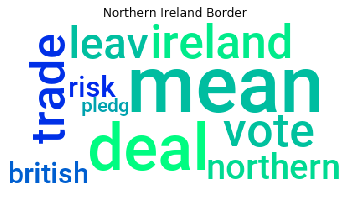

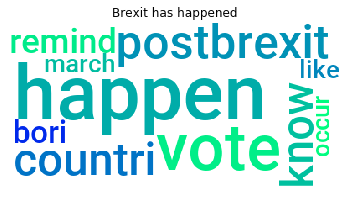

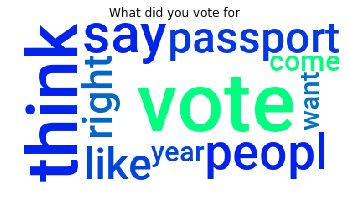

In [48]:
def show_wordcloud(topic_name: str, topic_dict: Dict) -> None:
    """
    Accepts name of topic and dictionary of words and frequencies.
    Plots words and frequencies as a WordCloud object using
    matplotlib. Saves the figure to file using 'topic' as the
    filename (so topic should contain only A-Z, a-z, 0-9, _, -)
    """
    wc = WordCloud(font_path='brexittweets/Roboto-Medium.ttf',
               background_color='white',
               colormap='winter')
    plt.figure()
    plt.imshow(wc.fit_words(topic_dict))
    plt.axis("off")
    title = ' '.join(topic_name.split('_'))
    plt.title(title)
    try:
        plt.savefig(pltpath + f'/word_clouds/{topic_name}.png')
    except FileNotFoundError:
        print("Error: {topic} not saved to file.")
        print("Invalid filename - please do not include '/' or '\'")
    plt.show()

show_wordcloud("Northern_Ireland_Border", topic_0_dict)
show_wordcloud("Brexit_has_happened", topic_1_dict)
show_wordcloud("What_did_you_vote_for", topic_2_dict)

## References

BBC News (2019a) 'General Election 2019: A really simple guide', available at
[https://www.bbc.co.uk/news/uk-politics-49826655](https://www.bbc.co.uk/news/uk-politics-49826655)
[accessed 16/03/20]

BBC News (2019b) 'General election 2019: Boris Johnson vows to 'forge a new Britain'', available at
[https://www.bbc.co.uk/news/election-2019-50532000](https://www.bbc.co.uk/news/election-2019-50532000)
[accessed 16/03/20]

BBC News (2020a) 'Brexit: NI deadline is 'almost impossible' to meet', available at 
[https://www.bbc.co.uk/news/uk-northern-ireland-51093782](https://www.bbc.co.uk/news/uk-northern-ireland-51093782)
[accessed 16/03/20]

BBC News (2020b) 'New blue British passport rollout to begin in March', 
available at [https://www.bbc.co.uk/news/uk-51585018](https://www.bbc.co.uk/news/uk-51585018) 
[accessed 16/03/20]

Prabhakaran, s. (2018) 'Topic Modeling with Gensim (Python)', *Machine Learning Plus* [online] available at
[https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)
[accessed 09/03/2020]

The Guardian (2020) 'Brexit: EU and US trade deals 'at risk' if UK reneges on Northern Ireland pledges', available at
[https://www.theguardian.com/politics/2020/feb/23/brexit-uk-reneging-on-northern-ireland-pledges-risks-trade-deals-with-us-and-eu](https://www.theguardian.com/politics/2020/feb/23/brexit-uk-reneging-on-northern-ireland-pledges-risks-trade-deals-with-us-and-eu)
[accessed 16/03/20]

BrexitBot (2020) 'Hi, just a reminder that Brexit has not happened yet. It is due to occur on the 29th March 2019',
Twitter [online] available at 
[https://twitter.com/hasnthappened/with_replies](https://twitter.com/hasnthappened/with_replies) [accessed 10/04/2020] 